In [1]:
import numpy as np
import tensorflow as tf
import binvox_rw
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def center(voxin):
    f = np.squeeze(np.max(voxin, axis=(2, 1)))
    s = np.squeeze(np.max(voxin, axis=(2, 0)))
    t = np.squeeze(np.max(voxin, axis=(1, 0)))

    nzf = np.sum(f == 0) 
    nzs = np.sum(s == 0)
    nzt = np.sum(t == 0)

    i_f = np.argmax(f)
    l_f = np.sum(f > 0)
    i_s = np.argmax(s)
    l_s = np.sum(s > 0)
    i_t = np.argmax(t)
    l_t = np.sum(t > 0)

    zfl = np.floor(nzf/2.0).astype(int)
    zfr = nzf - zfl
    zsl = np.floor(nzs/2.0).astype(int)
    zsr = nzs - zsl
    ztl = np.floor(nzt/2.0).astype(int)
    ztr = nzt - ztl  

    voxout = np.zeros_like(voxin)
    voxout[zfl:128-zfr, zsl:128-zsr, ztl:128-ztr] = voxin[i_f:i_f+l_f, i_s:i_s+l_s, i_t:i_t+l_t,]
    return voxout

In [3]:
class voxel_gen(Sequence):
    def __init__(self, x_set, batch_size=32, dim=(128,128,128)):
        self.x = x_set # path for each dataset : models/models-binvox-solid
        self.batch_size = batch_size
        self.dim = dim

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x_set_temp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(x_set_temp)
        return X
    
    def __data_generation(self, x_set_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))

        for i, x_set in enumerate(x_set_temp):
            # Store sample
            with open(str(x_set), 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            X[i,] = np.expand_dims(model.data, axis=-1)
        return X

In [4]:
def customGen(batch_size=32):
    gen = ImageDataGenerator(rescale=1/255.)
    view0 = gen.flow_from_directory(
        "models/models-screenshots/view0",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view1 = gen.flow_from_directory(
        "models/models-screenshots/view1",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view2 = gen.flow_from_directory(
        "models/models-screenshots/view2",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view3 = gen.flow_from_directory(
        "models/models-screenshots/view3",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)
    
    voxels = Path("models/models-binvox-solid/data")
    fvoxels = [f for f in voxels.iterdir() if f.is_file()]
    
    out = voxel_gen(fvoxels, batch_size)
    while True:
        for x1, x2, x3, x4, y in zip(view0, view1, view2, view3, out):
            yield [x1,x2,x3,x4], y

In [6]:
gen1 = customGen(1)

100f39dce7690f59efb94709f30ce0d2


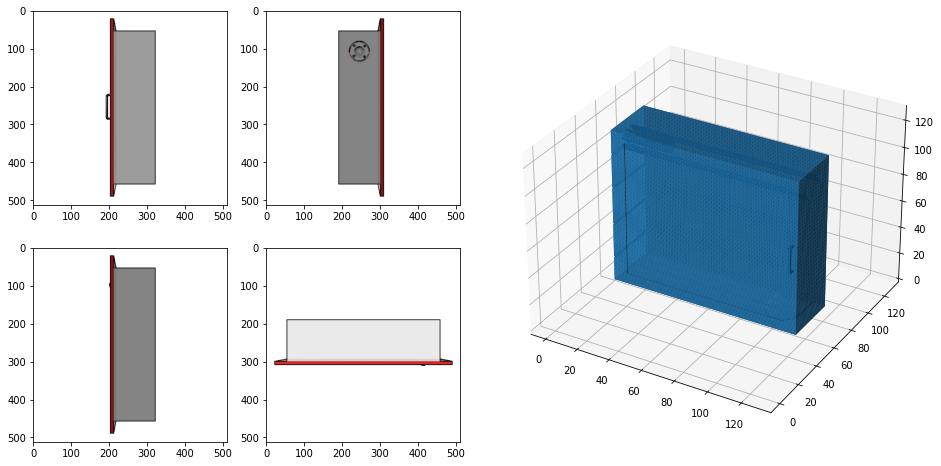

101354f9d8dede686f7b08d9de913afe


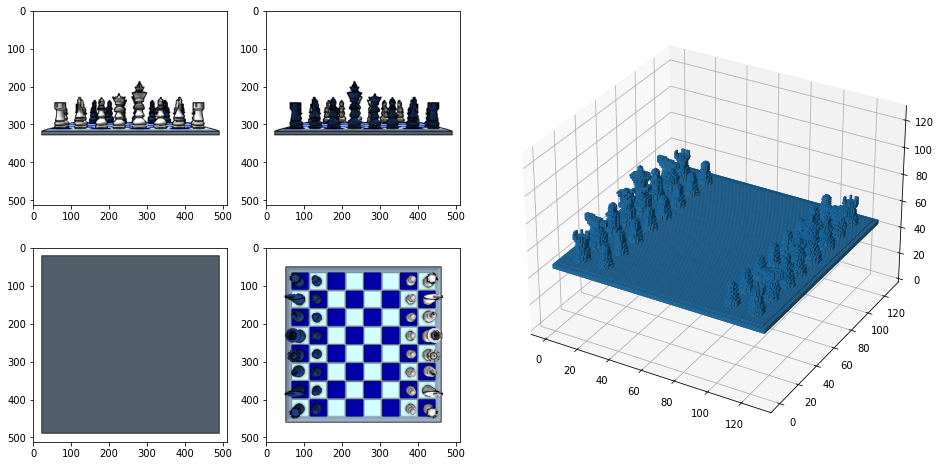

1018f01d42ae7fad52249d8432f6087e


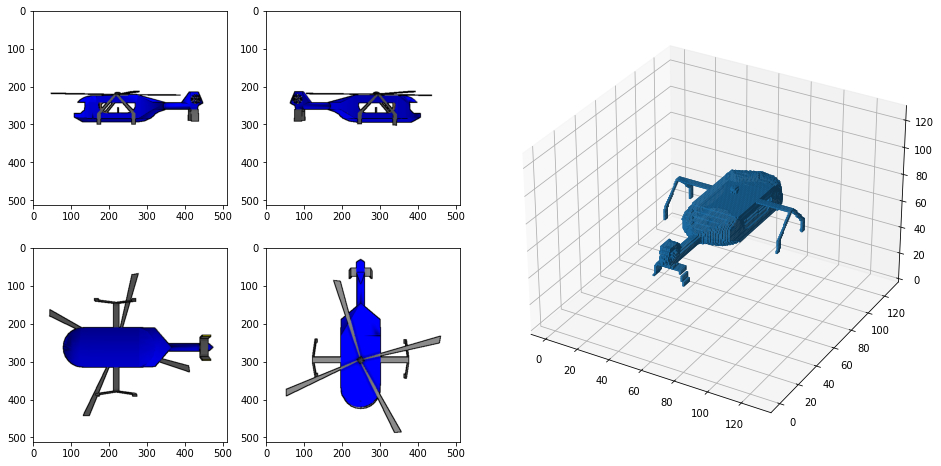

102273fdf8d1b90041fbc1e2da054acb


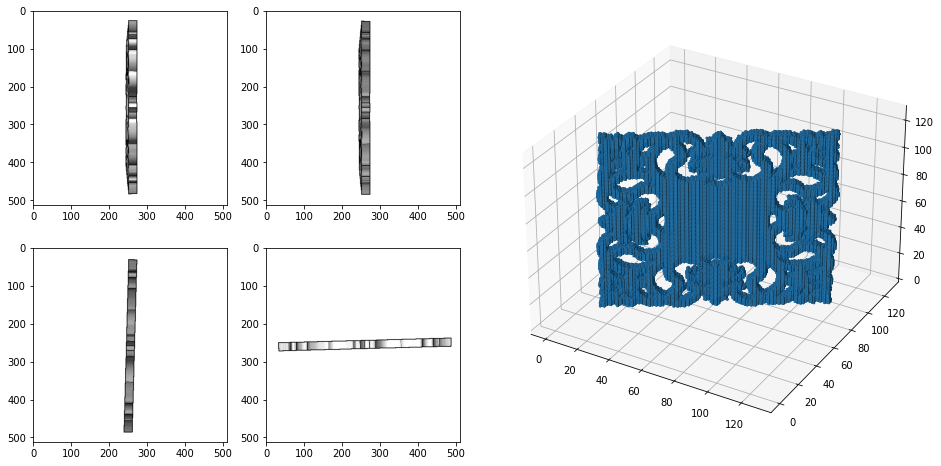

1022fe7dd03f6a4d4d5ad9f13ac9f4e7


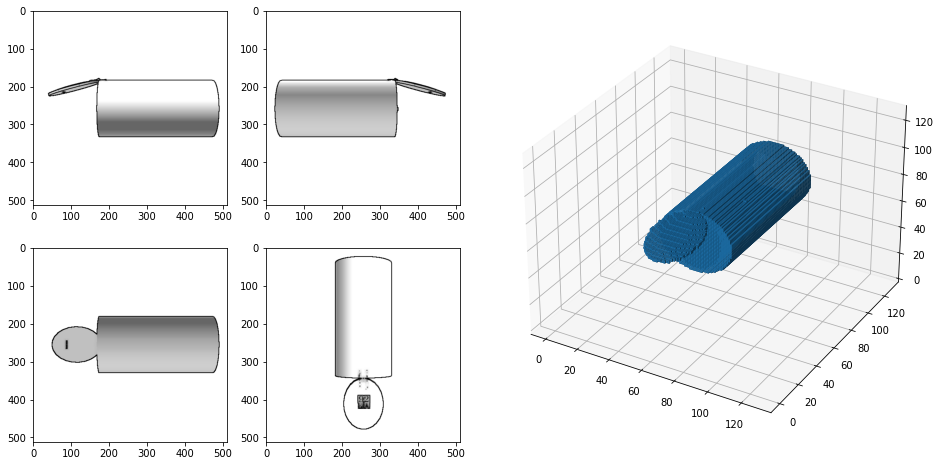

In [9]:
voxels = Path("models/models-binvox-solid/data")
fvoxels = [f for f in voxels.iterdir() if f.is_file()]
count = -1
for X, y in gen1:
    count += 1
    if count<5:
        print(fvoxels[count].stem)
        fig = plt.figure(figsize=(16, 8))
        ax1 = plt.subplot2grid((2, 4), (0, 0))
        ax2 = plt.subplot2grid((2, 4), (0, 1))
        ax3 = plt.subplot2grid((2, 4), (1, 0))
        ax4 = plt.subplot2grid((2, 4), (1, 1))
        ax5 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2, projection='3d')
        y = center(np.squeeze(y))
        ax1.imshow(np.squeeze(X[0]))
        ax2.imshow(np.squeeze(X[1]))
        ax3.imshow(np.squeeze(X[2]))
        ax4.imshow(np.squeeze(X[3]))
        ax5.voxels(np.squeeze(y))
        plt.show()
    else:
        break

In [6]:
import skimage.measure
from skimage.measure import block_reduce
voxels = Path("models/models-binvox-solid/data/00001.binvox")
with open(voxels, 'rb') as f:
    model = binvox_rw.read_as_3d_array(f)
# model.dims 
#model.data
image=(np.array(model.data))*1
print(image.shape)
#.reshape(model.dims)+0
k=skimage.measure.block_reduce(image, (2,2,2), np.max)
print(k.shape)

(128, 128, 128)
(64, 64, 64)


In [ ]:
depth = 30
height = 30
width = 30
input_channels = 3

inputs = tf.keras.Input(shape=(depth, height, width, input_channels))
layer = tf.keras.layers.MaxPooling3D(pool_size=3)
outputs = layer(inputs)  # Shape: (batch_size, 10, 10, 10, 3)